# Distinguish brids and planes
First download CIFAR-10 dataset, and preprocess. Including transform dataset to tensor, normalize image in each channel(RGB)

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
data_path = './data/CIFAR10'
cifar10 = datasets. CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor ())

100.0%


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


## Normalizing
Normalizing data channels, to make every channel have same mean and std.

In [3]:
imgs = torch.stack ([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [4]:
ch_mean = imgs. view(3, -1). mean (dim=1)
ch_mean

tensor([0.4914, 0.4822, 0.4465])

In [5]:
ch_std = imgs. view(3, -1). std(dim=1)
ch_std

tensor([0.2470, 0.2435, 0.2616])

In [7]:
normlizer = transforms.Normalize (ch_mean, ch_std)
cifar10_norm = datasets.CIFAR10(data_path, train=True, download=True,
    transform=transforms.Compose ([transforms.ToTensor(), normlizer]))

Files already downloaded and verified


In [9]:
imgs_val = torch.stack([img_t for img_t, _ in cifar10_val], dim=3)
ch_mean_val = imgs_val.view(3, -1) .mean(dim=1)
ch_std_val = imgs_val.view(3, -1).std(dim=1)
cifar10_norm_val = datasets.CIFAR10(data_path, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(ch_mean_val, ch_std_val)]))

Files already downloaded and verified


## Regroup dataset
For the task we will archive, we only need the dataset contains the 'bird" and 'airplane'.

In [12]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

# regroup dataset
cifar2 = [(img, label_map[label]) for img, label in cifar10_norm if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_norm_val if label in [0, 2]]

# regroup dataset in another way (Subset)

## Fully connected model
Now we construct a simple model.

In [13]:
n_out = 2 # output airplane or bird
model = nn. Sequential(
    nn.Linear(
        3072, # 32*32*3
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512, n_out,
    ),
    nn.Softmax(dim=1)
)

Just checkout the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


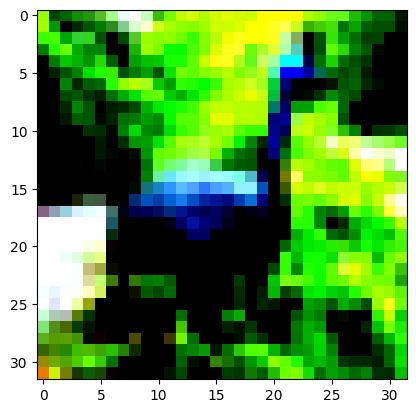

In [15]:
img, _ = cifar2[0]
plt. imshow(img. permute(1,2,0))
plt. show()

Have a glance on current untrained model. But we need make tersor in correct dimension

In [16]:
img_batch_test = img. view(-1). unsqueeze(0)
print (img_batch_test. shape)
out = model (img_batch_test)
out

torch.Size([1, 3072])


tensor([[0.6225, 0.3775]], grad_fn=<SoftmaxBackward0>)

## Modify classification loss
Softmax focus on classification in probability on 1.0 not on the probability higher than others. So We change softmax to logsoftmax

In [17]:
n_out = 2 # output airplane or bird
model = nn. Sequential(
    nn.Linear(
        3072, # 32*32*3
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512, n_out,
    ),
    nn.LogSoftmax(dim=1)
)

## Training model
Use small batch update parameter of model. There are 2 strategies on training and updating parameters, one is train all data in train set and update once; another is training a random batch of whole train set. The second strategy can have a approach of the first one, but have a better efficience.

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
learning_rate = 1e-2
optimizer = torch.optim.SGD(model. parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer. zero_grad()
        loss. backward()
        optimizer. step()
    print(f"Epoch: {epoch}, Loss: {float(loss)}")

Epoch: 0, Loss: 0.5507182478904724
Epoch: 1, Loss: 0.42217931151390076
Epoch: 2, Loss: 0.4130636155605316
Epoch: 3, Loss: 0.2967418432235718
Epoch: 4, Loss: 0.4247249364852905
Epoch: 5, Loss: 0.35586124658584595
Epoch: 6, Loss: 0.45009705424308777
Epoch: 7, Loss: 0.3657110929489136
Epoch: 8, Loss: 0.68947434425354
Epoch: 9, Loss: 0.2333284616470337
Epoch: 10, Loss: 0.20555593073368073
Epoch: 11, Loss: 0.2253136783838272
Epoch: 12, Loss: 0.539772093296051
Epoch: 13, Loss: 0.5877918601036072
Epoch: 14, Loss: 0.29031485319137573
Epoch: 15, Loss: 0.2709488868713379
Epoch: 16, Loss: 0.1970735788345337
Epoch: 17, Loss: 0.29019540548324585
Epoch: 18, Loss: 0.22656910121440887
Epoch: 19, Loss: 0.12914486229419708
Epoch: 20, Loss: 0.1977732926607132
Epoch: 21, Loss: 0.19939710199832916
Epoch: 22, Loss: 0.24523594975471497
Epoch: 23, Loss: 0.09838718920946121
Epoch: 24, Loss: 0.16564147174358368
Epoch: 25, Loss: 0.08824323862791061
Epoch: 26, Loss: 0.5560765266418457
Epoch: 27, Loss: 0.242399051